In [2]:
from nflows import models
import torch
from torchvision.transforms import ToPILImage

/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = models.get_glow_model(2, (3,320,320))
model.load("/home/ubuntu/nflows/experiment_04_bubbles/model_56.pth")

/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/normflows/flows/mixing.py:72: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  Q = torch.qr(torch.randn(self.num_channels, self.num_channels))[0]
/home/ubuntu/.cache/pypoetry/virtualenvs/nflows-VYLojdXp-py3.8/lib/python3.8/site-packages/torch/_tensor.py:662: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivot

In [4]:
from collections import defaultdict
flow_data = defaultdict(dict)

def add_hook(name):
    def flow_hook(model, input, output):
        if not isinstance(input[0], int):
            flow_data[name]["input"] =  input[0].detach()
        else:
            flow_data[name]["input"] =  input[0]
        flow_data[name]["output"] = output[0].detach()
    return flow_hook

for fm_cnt, flow_module in enumerate(model.flows):
    for f_cnt, flow in enumerate(flow_module):
        flow.register_forward_hook(add_hook(f"flow_{fm_cnt}_{f_cnt}"))

# for q_cnt, q_module in enumerate(model.q0):
#     q_module.register_forward_hook(add_hook(f"q0_{q_cnt}"))
# with torch.no_grad():
s = model.sample(10, y=torch.tensor([1], dtype=torch.int64))
# flow_data

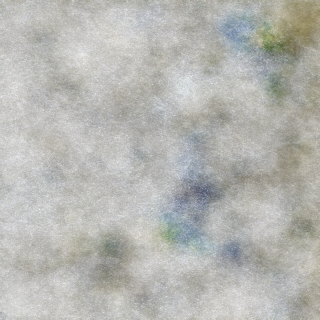

In [5]:
transform = ToPILImage()
transform(s[0].squeeze(0))
# transform(flow_data["output"].squeeze(0))

In [6]:
from PIL import Image
def get_concat_h_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_h_multi_blank(im_list):
    _im = im_list.pop(0)
    for im in im_list:
        _im = get_concat_h_blank(_im, im)
    return _im

def get_concat_v_multi_resize(im_list, resample=Image.Resampling.BICUBIC):
    min_width = min(im.width for im in im_list)
    im_list_resize = [im.resize((min_width, int(im.height * min_width / im.width)),resample=resample)
                      for im in im_list]
    total_height = sum(im.height for im in im_list_resize)
    dst = Image.new('RGB', (min_width, total_height))
    pos_y = 0
    for im in im_list_resize:
        dst.paste(im, (0, pos_y))
        pos_y += im.height
    return dst

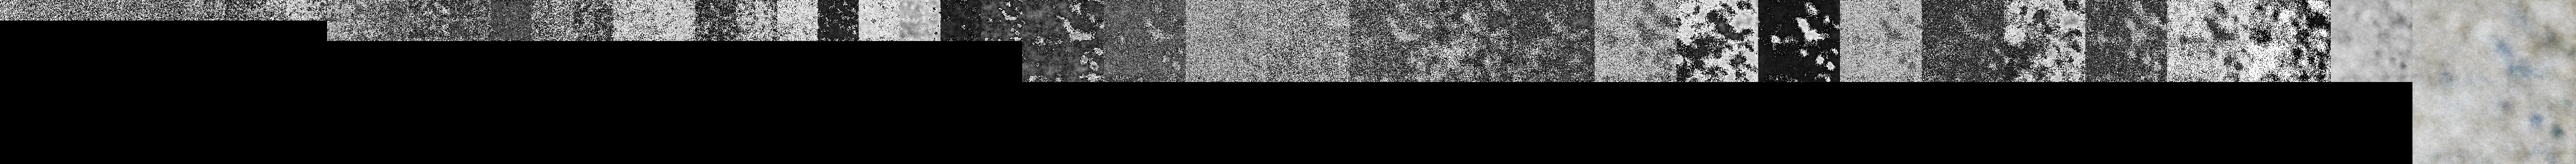

: 

In [7]:
s = model.sample(10, y=torch.tensor([1], dtype=torch.int64))
images = []
transform = ToPILImage()
for k, v in flow_data.items():
    if v["output"].shape[1] < 4:
        images.append(transform(v["output"].squeeze(0)))
    else:
        images.append(transform(v["output"].squeeze(0).mean(0)))

get_concat_h_multi_blank(images)

In [23]:
from nflows.data import get_mnist, get
_, test_ds, num_classes, input_dim = get_mnist(batch_size=10) 

In [24]:
sample = next(iter(test_ds))


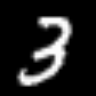

In [25]:
transform(sample[0][2])

In [26]:
with torch.no_grad():
    log_probs = model.log_prob(sample[0],y=torch.tensor([2]))

RuntimeError: The size of tensor a (4) must match the size of tensor b (12) at non-singleton dimension 1

In [11]:

torch.exp(log_probs)/ (torch.exp(log_probs).sum())

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [45]:
model.q0[0].hoo

TypeError: 'ClassCondDiagGaussian' object is not subscriptable